In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; margin:auto;}</style>"))
display(HTML("<style>div.text_cell { max-width:1000px !important; margin:auto;}</style>"))
display(HTML("<style>.input { max-width:1100px !important; width:95%; margin:auto;}</style>"))
display(HTML("<style>.output { max-width:100% !important; margin:auto; align-items:center;}</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

from interp import interpolator, tomo_interpolator
import RegTomoRecon as rtr
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

filename = 'data/dogbones'
if 'recon' not in locals():
    recon = {}

%matplotlib notebook
def figure(name='tmp', figsize=(9.5,6), **kwargs):
    plt.close(name)
    return plt.figure(name, figsize=figsize, **kwargs)
def show(): plt.tight_layout(); F = plt.gcf(); F.canvas.draw(); F.canvas.flush_events()

# Define phantoms

<IPython.core.display.Javascript object>


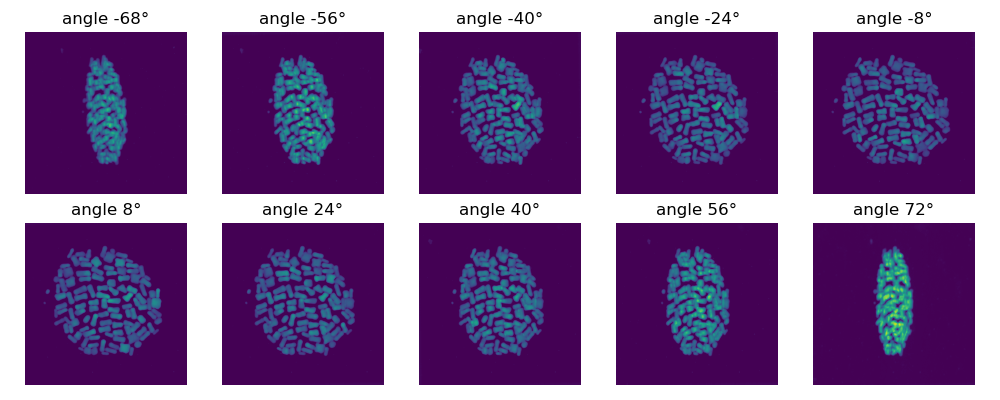

In [3]:
data = np.load(filename +'.npz')
angles, data = data['angles'][::2], data['data'][::2]
subind = np.linspace(0,len(angles)-1,10).astype(int)

data = np.maximum(data-.7,0)/(data.max()-.7) # normalised for mean-0 noise

figure('data', figsize=(10,4))
for i,j in enumerate(subind):
    plt.subplot(2,5,i+1).imshow(data[j],vmin=0,vmax=1,origin='lower'); plt.title('angle %d°'%angles[j]); plt.axis('off')
show()

# Example samples

In [4]:
def Lissajous(a,b, threshold=0):
    # Lissajous curves are formed of two sinosoids
    
    if threshold==0:
        t = [0,2*np.pi]
    else:
        # compute times between 0 and 2pi where we want |cos(t)| <= 1-threshold
        t0,i = np.arccos(1-threshold), np.arange(np.ceil(2*max(a,b))+2)[:,None]
        t0 = np.concatenate( (t0+np.pi*i, -t0+np.pi*(i+1)), axis=1)
        ta, tb = t0/a, t0/b
        ta, tb = ta[ta[:,0]<2*np.pi], tb[tb[:,0]<2*np.pi]
        
        t = []
        while len(ta)>0 and len(tb)>0:
            if tb[0,0] < ta[0,0]:
                tb, ta = ta, tb # ta is the interval starting first
            if ta[0,1]<tb[0,0]: # first interval ends before second
                ta = ta[1:]
            elif ta[0,1]>tb[0,1]: # first interval ends after second
                t.append(tb[0])
                tb = tb[1:]
            else:
                t.append(np.array([tb[0,0],ta[0,1]]))
                ta = ta[1:]
        if len(t)==0:
            raise ValueError('threshold is too high, no valid times found')
        t[-1][1] = min(2*np.pi,t[-1][1])
    t = np.array(t).reshape(-1,2)
        
    def lissajous(T):
        n = int(np.ceil(T/t.shape[0])) # number of points per segment
        points = []
        for tt in t:
            points.append(np.concatenate((
                np.cos(a*np.linspace(*tt,n))[:,None],
                np.cos(b*np.linspace(*tt,n))[:,None]), axis=1))
        return .5+.5/(1-threshold)*np.concatenate(points, axis=0)[:T]
    return lissajous

def Uniform():
    # Uniform point sampling
    def rand(T):
        np.random.seed(1)
        return np.random.rand(T,2)
    return rand

def Grid():
    # Uniform grid sampling
    def rand(T):
        n = int(round(T**.5)) # T samples is roughly an nxn grid
        m = np.linspace(0,1,n+2)[1:-1]
        x,y = np.meshgrid(m,m)
        return np.concatenate((x.reshape(-1,1),y.reshape(-1,1)), axis=1)
    return rand

def Lines(n):
    # Samples are taken down random straight lines of length n pixels
    def lines(T): # T is number of samples
        np.random.seed(1)
        n_curves = T//n+1
        curves = np.random.rand(n_curves,1,2), np.random.rand(n_curves,1,2) # random start and end points
        for i in range(n_curves):
            tmp = [(0,0),(0,1),(1,0),(1,1)]
            for j in range(2):
                k = np.random.randint(4-j)
                k = tmp.pop(k)
                curves[j][i,0,k[0]] = k[1]
        curves = curves[0] + np.linspace(0,1,n)[None,:,None]*(curves[1]-curves[0])
        return curves.reshape(-1,2)[:T]
    return lines


## Example curves

In [5]:
T = data[0].size//10 # 10% sampling schemes
CURVES = (('Lissajous',Lissajous(100,101,.2)), ('Uniform', Uniform()), ('Grid', Grid()))

# param = {
#     'order': 1, 'iters':2, 'weight':5, 'TGV':False, # parameters for inpainting
#     'iters_indirect':3, 'weight_indirect': 2, # parameters for indirect reconstruction
#     'iters_direct': 3, 'weight_direct': 2 # parameters for direct reconstruction
# }
param = {
    'order': 1, 'iters':3, 'weight':1, 'TGV':True, # parameters for inpainting
    'iters_indirect':3, 'weight_indirect': 3, # parameters for indirect reconstruction
    'iters_direct': 3, 'weight_direct': 2 # parameters for direct reconstruction
}

## Example disc samples

<IPython.core.display.Javascript object>


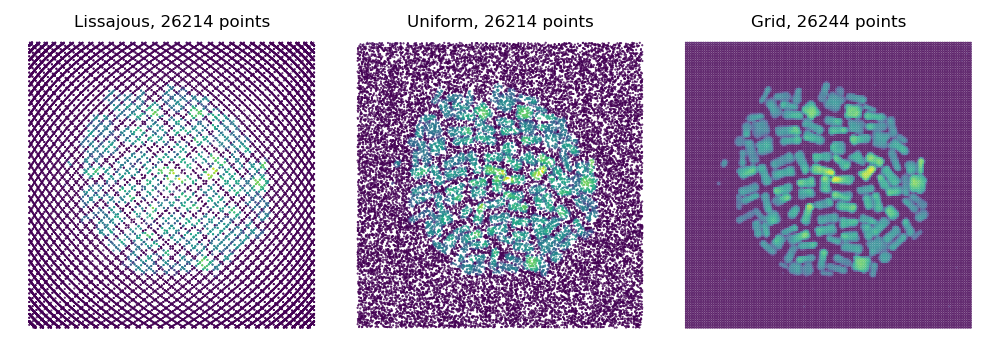

In [6]:
figure('Samples',(10,3.5))
D = data[subind[len(subind)//2]]
ax = []
for i,(s,f) in enumerate(CURVES):
    L = f(T); I = interpolator(D.shape, L)
    ax = plt.subplot(1,3,i+1).scatter(I.image[:,1],I.image[:,0], s=6e3/T, c=I(D), vmin=D.min(), vmax=D.max()); 
    plt.title(s+', %d points'%L.shape[0]); plt.axis('off'); plt.axis('equal')
show()

## Data interpolation

In [7]:
# this takes about 2h:45
for i,(s,f) in enumerate(CURVES):
    myfilename = filename + '_inpaint_%s_%d_%d_%d'%(s, param['order'],param['iters'],param['weight'])
    if param['TGV']:
        myfilename += '_TGV'
    I = interpolator(data.shape[1:], f(T)).getOperator()
    try:
#         raise
        recon[s] = np.load(myfilename+'.npz')['recon'].astype('float32')
    except Exception:
        recon[s] = recon.get(s,[])
        if len(recon[s])==len(angles):
            recon[s] = []
    for j in tqdm(range(len(angles)), desc=s):
        D = data[j]
        if len(recon[s])>j:
            continue
        if param['TGV']:
            alg = rtr.TGV(D.shape, weight=np.array([100,1/100])*10**(-param['weight']), op=I)
            recon[s].append(alg.run(data=I(D), steps='ada', callback='silent',
                                   maxiter=(10 if s=='Lissajous' else 3)*10**param['iters']).astype('float32'))
        else:
            alg = rtr.TV(D.shape, order=param['order'], op=I, alg='SplitBregman')
            recon[s].append(alg.run(data=I(D), maxiter=10**param['iters'], weight=10**(-param['weight']), tau=10, callback='silent'))
    recon[s] = np.array(recon[s])
                
    np.savez_compressed(myfilename,recon=recon[s])

Lissajous:   0%|          | 0/36 [00:00<?, ?it/s]

Uniform:   0%|          | 0/36 [00:00<?, ?it/s]

Grid:   0%|          | 0/36 [00:00<?, ?it/s]

In [8]:
# j = subind[1]
# D = np.ascontiguousarray(data[j][200:300,200:300])
# # I = interpolator(D.shape, Lissajous(20,21,.45)(T//25))
# I = interpolator(D.shape, Uniform()(T//25))
# # I = interpolator(D.shape, CURVES[0][1](T))
# tmp = [None]*4
# # for i,tau in enumerate((10,30,100,300)):
# for i,tau in enumerate((.1,1,10,100)):
# #     if i>0:
# #         continue
# #     alg = rtr.TV(D.shape, order=1, op=I.getOperator(), alg='SplitBregman')
# #     if i==0:
# #         tmp[i] = alg.run(data=I(D), maxiter=10000, callback_freq=1000, weight=1e-5, tau=10, callback=('primal','gap','step'))[0]        
# #         print(abs(I(D-tmp[0]).max()), alg.f(tmp[0].ravel()/alg.dataScale) + alg.g(tmp[0].ravel()/alg.dataScale))
# #         print(abs(I(D-tmp[2]).max()), alg.f(tmp[2].ravel()/alg.dataScale) + alg.g(tmp[2].ravel()/alg.dataScale), '\n\n')
# #         alg = rtr.SmoothTV(D.shape, order=1, op=I.getOperator(), eps=1e-5)
# #     if i==2:
# #         tmp[i] = alg.run(data=I(D), maxiter=10000, callback_freq=1000, weight=1e-5, callback=('primal', 'step'))[0]
# #         print(abs(I(D-tmp[0]).max()), alg.f_Df(tmp[0].ravel()/alg.dataScale,False))
# #         print(abs(I(D-tmp[2]).max()), alg.f_Df(tmp[2].ravel()/alg.dataScale,False), '\n\n')

#     alg = rtr.TGV(D.shape, weight=np.array([tau,1/tau])*1e-1, op=I.getOperator())
#     tmp[i] = alg.run(data=I(D), maxiter=3e3, callback_freq=10**3, steps='ada', callback=('primal','gap','step'))[0]

#     tmp[i].shape = D.shape
# #     print(abs(I(D-tmp[i]).max()), alg._prim, '\n\n')
# #     print(abs(I(D-tmp[i]).max()), (alg.f(tmp[i]/alg.dataScale) + alg.g(tmp[i]/alg.dataScale))*10**3.5, '\n\n')
# [print(('%.1e    '*3)%(abs(I(t-D)).max(), abs(I(t-D)).mean(), abs(t-D).mean())) for t in tmp]

# figure('tmp',(9.5,4))
# for i in range(4):
#     plt.subplot(2,4,i+1).imshow(tmp[i],origin='lower',vmin=0,vmax=1); plt.axis('off')
#     plt.subplot(2,4,i+5).imshow(abs(tmp[i]-D),origin='lower',vmin=0,vmax=.1); plt.axis('off')
# #     plt.scatter(I.image[:,1], I.image[:,0], s=6e3/T, c='r', vmin=D.min(), vmax=D.max())
# show()

# Interpolation plots

<IPython.core.display.Javascript object>


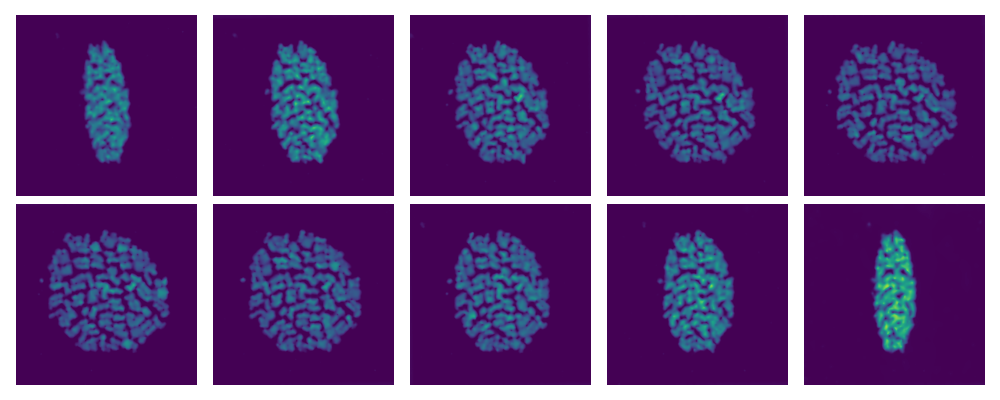

Data error:  4.9e-04    5.9e-04    5.8e-04    7.8e-04    8.3e-04    7.5e-04    7.8e-04    7.9e-04    7.4e-04    1.5e-03
True error:  9.7e-03    1.4e-02    1.7e-02    2.1e-02    2.5e-02    2.4e-02    2.4e-02    2.0e-02    1.4e-02    1.0e-02


<IPython.core.display.Javascript object>


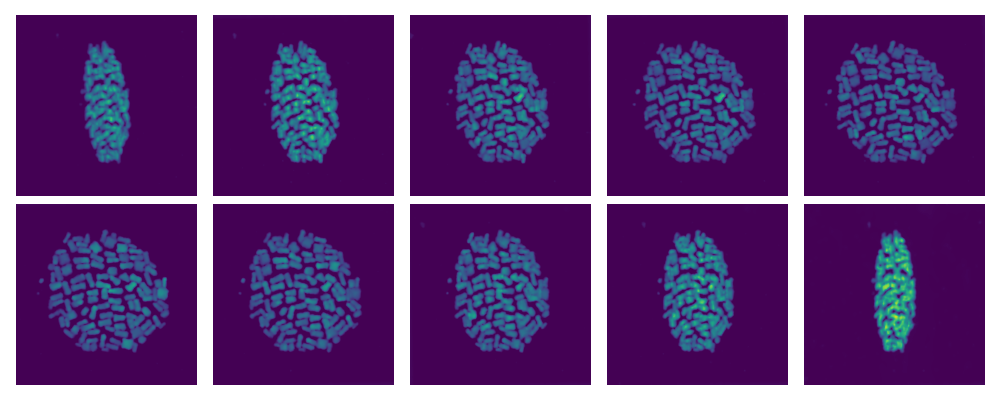

Data error:  9.0e-04    1.0e-03    1.4e-03    1.3e-03    1.7e-03    1.5e-03    1.4e-03    1.5e-03    1.2e-03    1.6e-03
True error:  4.2e-03    5.7e-03    7.1e-03    8.3e-03    1.0e-02    9.4e-03    9.6e-03    8.2e-03    6.2e-03    4.6e-03


<IPython.core.display.Javascript object>


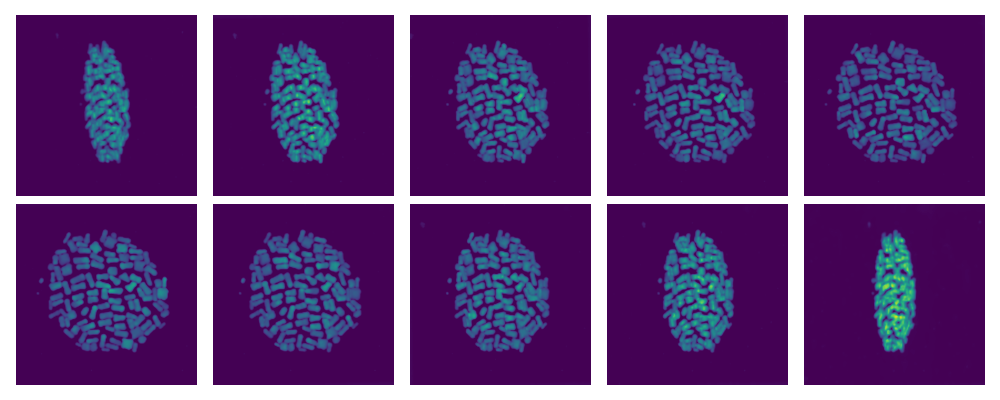

Data error:  6.8e-04    7.9e-04    7.6e-04    1.0e-03    9.4e-04    1.0e-03    9.7e-04    7.9e-04    8.5e-04    1.5e-03
True error:  3.0e-03    4.0e-03    5.0e-03    6.2e-03    7.1e-03    6.6e-03    6.8e-03    5.6e-03    4.6e-03    3.6e-03


In [9]:
for (s,f) in CURVES:
    F = figure('%s inpainting'%s,(10,4))
    I = interpolator(data.shape[1:], f(T)).getOperator()
    for i,j in enumerate(subind):
        plt.subplot(2,5,i+1).imshow(recon[s][j],origin='lower',vmin=0,vmax=1,); plt.axis('off')
    print('Data error: ','    '.join('%.1e'%(abs(I(data[j]-recon[s][j])).mean()/I(data[j]).max()) for j in subind))
    print('True error: ','    '.join('%.1e'%(abs(data[j]-recon[s][j]).mean()/I(data[j]).max()) for j in subind))
    show()

# Interpolation error plots

<IPython.core.display.Javascript object>


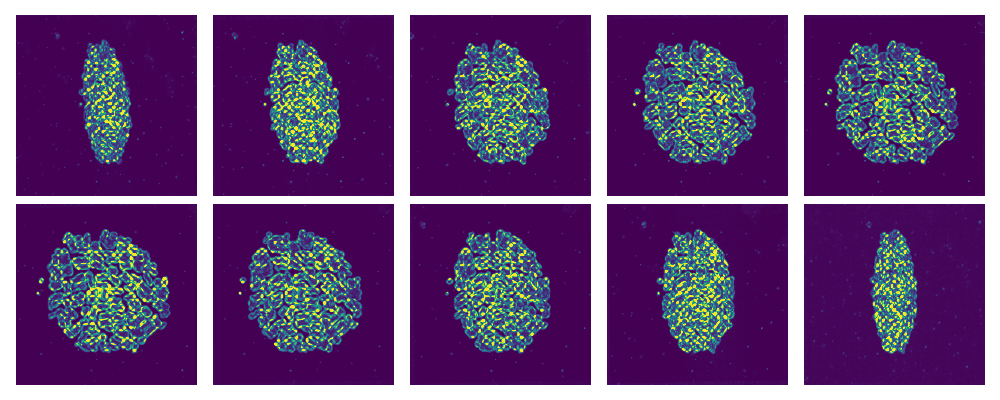

<IPython.core.display.Javascript object>


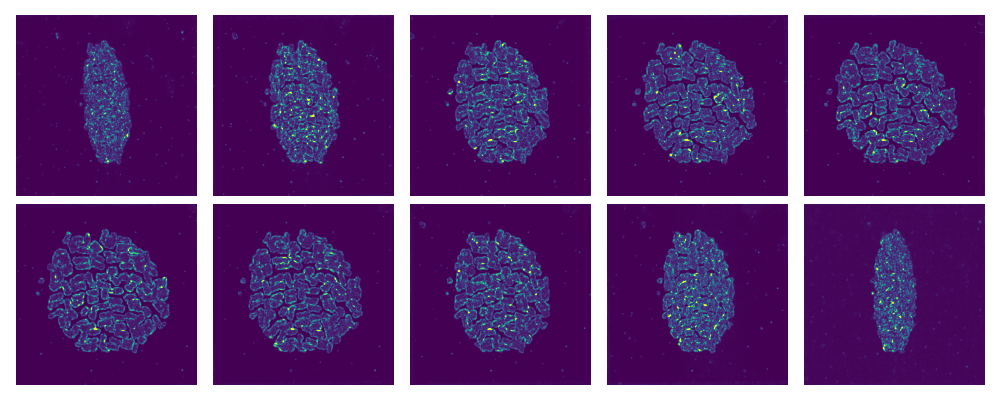

<IPython.core.display.Javascript object>


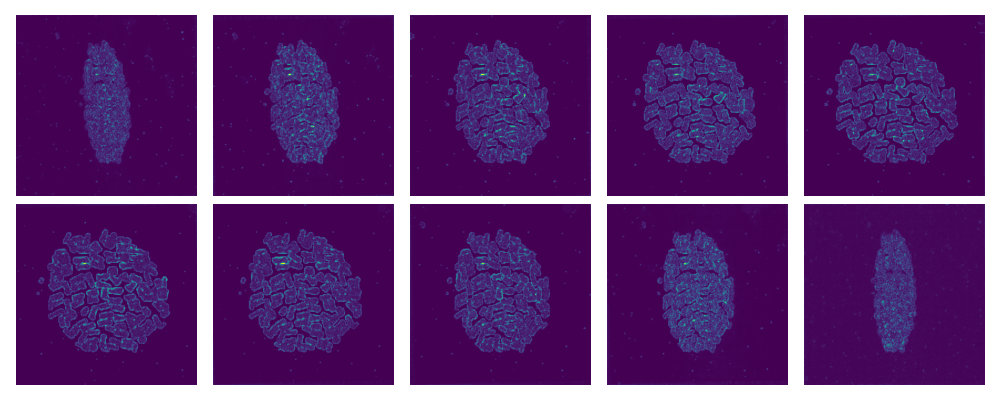

In [10]:
for (s,f) in CURVES:
    F = figure('%s error'%s,(10,4))
    for i,j in enumerate(subind):
        plt.subplot(2,5,i+1).imshow(abs(data[j]-recon[s][j]),vmin=0,vmax=1/10,origin='lower'); plt.axis('off')
    show()

# Indirect reconstructions

In [11]:
vol_shape = (512,40,512)

tomo_data = rtr.tomo_data(data, angles.astype(float), degrees=True, tilt_axis=1, stack_dim=0)
I = tomo_data.getOperator(vol_shape=vol_shape)

# fbp = rtr.FBP(filter='Ram-Lak', min_val=0, max_val=None)
# recon = fbp.run(data=tomo_data,op=I)
myfilename = filename + '_recon'
try:
    tomo_recon = np.load(myfilename+'.npz')['recon'].astype('float32')
#     raise
except Exception:
    alg = rtr.TV(shape=vol_shape, order=1)
    tomo_recon = alg.run(data=tomo_data, op=I, maxiter=1000, callback_freq=100, weight=0.001,
                    steps='adaptive', callback=('primal','gap','violation','step'))[0]
    np.savez_compressed(myfilename,recon=tomo_recon)
recon['direct '] = recon['indirect '] = tomo_recon

In [12]:
for i,(s,f) in enumerate(CURVES):
    myfilename = filename + '_recon_indirect_%s_%d_%d_%d_%d'%(s, param['order'],param['iters_indirect'],param['weight'],param['weight_indirect'])
    D = rtr.tomo_data(recon[s], angles.astype(float), degrees=True, tilt_axis=1, stack_dim=0)
    I = tomo_data.getOperator(vol_shape=vol_shape)

    try:
#         raise
        recon['indirect '+s] = np.load(myfilename+'.npz')['recon'].astype('float32')
    except Exception:
        alg = rtr.TV(shape=vol_shape, order=1) # Always order=1 volume penalty
        recon['indirect '+s] = alg.run(data=D, op=I, maxiter=.3*10**param['iters_indirect'], callback_freq=10**(param['iters_indirect']-1), weight=10**(-param['weight_indirect']),
                        steps='adaptive', callback=('primal','gap','violation','step'))[0]

#         alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-4)
#         recon['indirect '+s] = alg.run(x=tomo_recon.ravel(), data=D, op=I, maxiter=1000, 10**(-weight1), 
#                                      callback_freq=100, callback='step')[0]

        np.savez_compressed(myfilename,recon=recon['indirect '+s])


# Direct reconstructions

In [13]:
# this takes about 2h

for i,(s,f) in enumerate(CURVES):
    myfilename = filename + '_recon_direct_%s_%d_%d'%(s, param['iters_direct'],param['weight_direct'])
    D = np.concatenate([interpolator(data.shape[1:], f(T))(d)[None] for d in data], axis=0)
    I = tomo_interpolator(tomo_data.getOperator(vol_shape=vol_shape),
                          data.shape[1:], f(T)).getOperator()

    try:
#         raise
        recon['direct '+s] = np.load(myfilename+'.npz')['recon'].astype('float32')
    except Exception:
        alg = rtr.TV(shape=vol_shape, order=1)
        recon['direct '+s] = alg.run(data=D, op=I, maxiter=10**param['iters_direct'], callback_freq=10**(param['iters_direct']-1), weight=10**(-param['weight_direct']),
                        steps='adaptive', callback=('primal','gap','violation','step'))[0]

#         alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-4)
#         recon['direct '+s] = alg.run(x=tomo_recon.ravel(), data=D, op=I, maxiter=1000, weight=0.01, 
#                                      callback_freq=100, callback='step')[0]

        np.savez_compressed(myfilename,recon=recon['direct '+s])
    


In [14]:
# alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-2, pos=False)
# # %prun -s cumulative alg.run(data=D, op=I, maxiter=20, callback_freq=100, weight=0.1, steps='adaptive', callback=('primal','step'))
# from scipy.optimize.lbfgsb import _minimize_lbfgsb
# tmp = lambda: alg.run(data=D, op=I, maxiter=20, callback_freq=100, weight=0.1, steps='adaptive', callback='silent')
# %lprun -f _minimize_lbfgsb tmp()

# Plots for indirect/direct reconstructions respectively

<IPython.core.display.Javascript object>


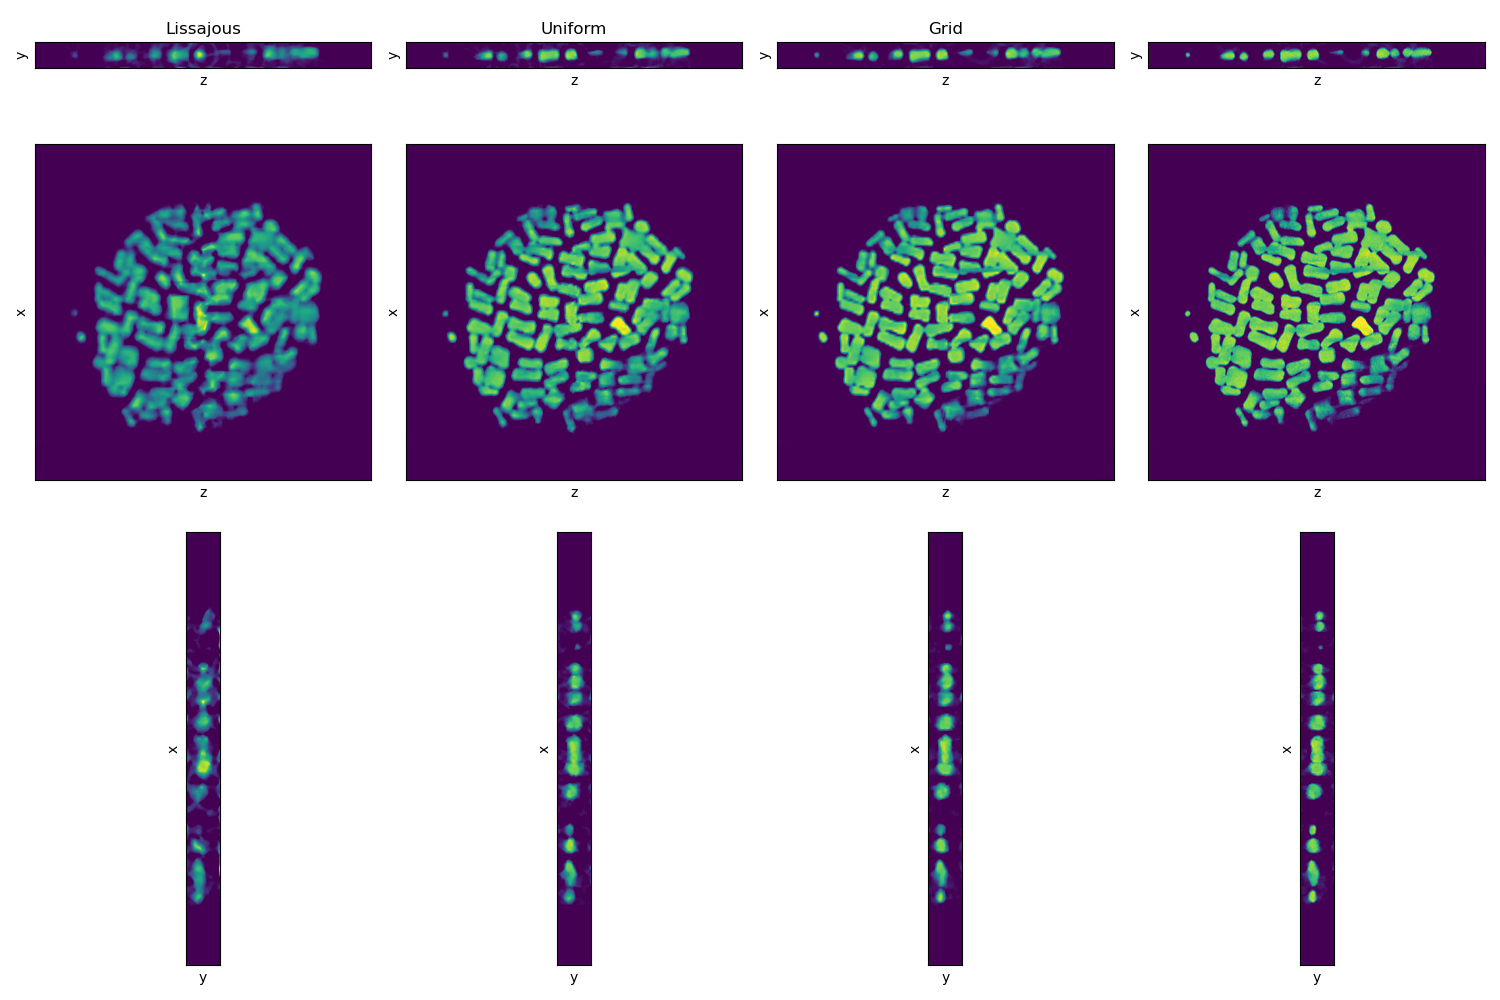

<IPython.core.display.Javascript object>


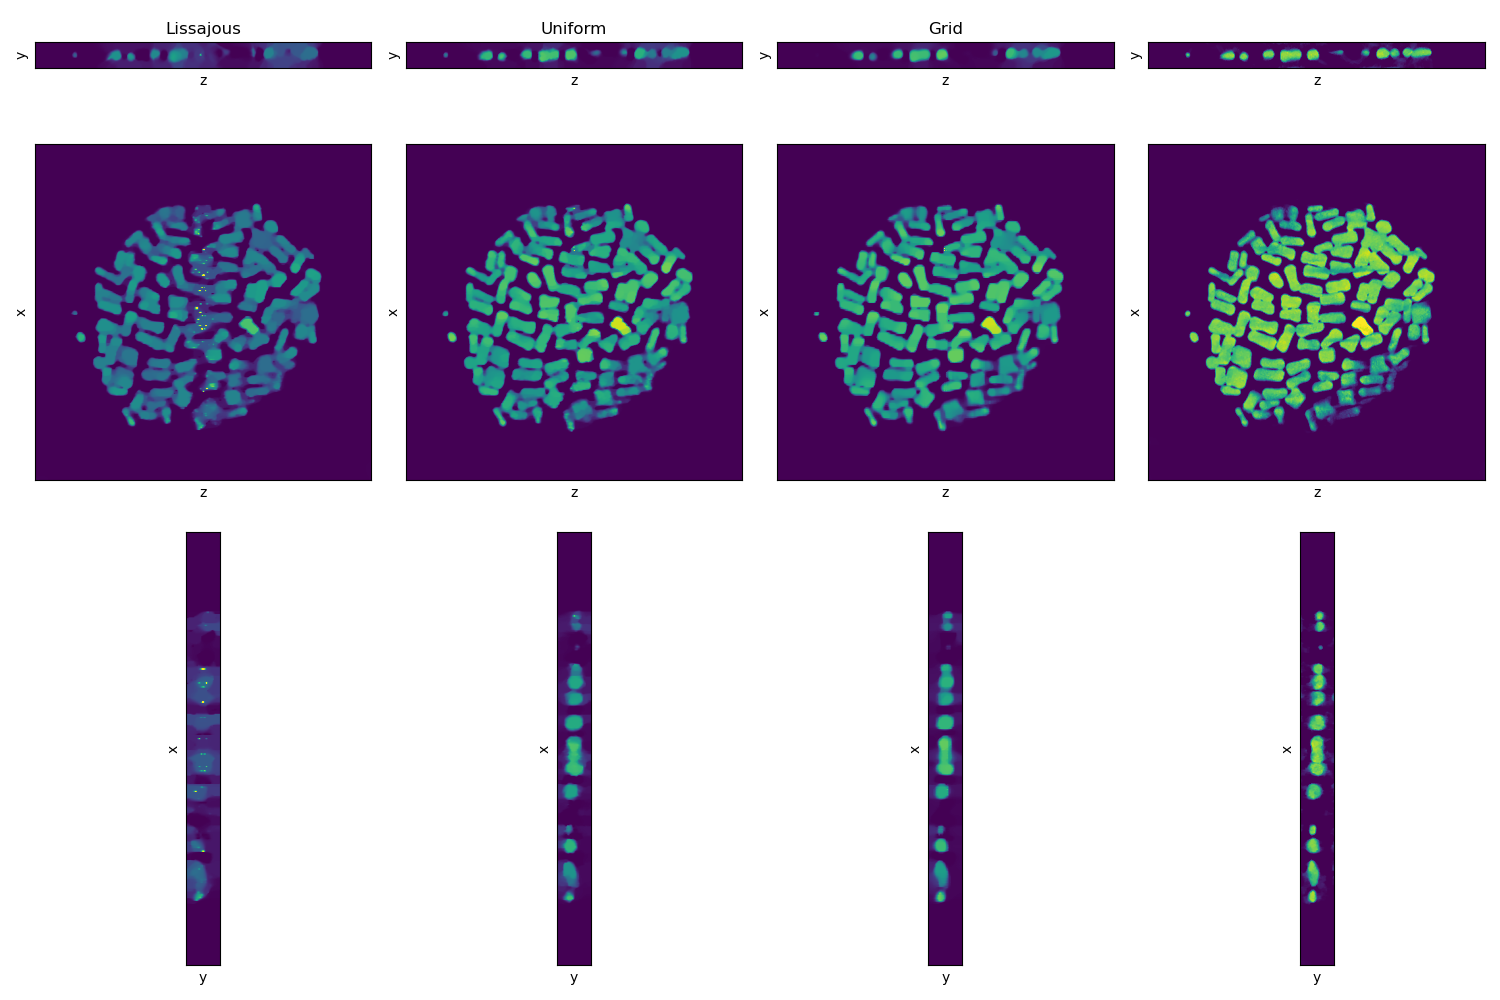

In [15]:
for tag in ('indirect ','direct '):
    F = figure(tag+'reconstructions',figsize=(15,10))
    ax = F.subplots(3,4,gridspec_kw={'height_ratios': [1,6,6]})
    for i, (s,f) in enumerate(CURVES+(('',None),)):
#     F = figure(tag+'reconstructions',figsize=(10,8))
#     ax = F.subplots(3,3,gridspec_kw={'height_ratios': [1,6,7]})
#     for i, (s,f) in enumerate(CURVES):
        R = recon[tag+s]
        aspect = ('equal','auto')[0]
        ax[0,i].set_title(s)
        ax[0,i].imshow(R[R.shape[0]//2], vmin=0, vmax=.027, aspect=aspect)
        ax[1,i].imshow(R[:,R.shape[1]//2], vmin=0, vmax=.027, aspect=aspect)
        ax[2,i].imshow(R[:,:,R.shape[2]//2], vmin=0, vmax=.027, aspect=aspect)
        for j in range(3):
    #         ax[j,i].imshow(R.sum(j), vmin=0, aspect=aspect)
#             ax[j,i].set_axis_off()
            ax[j,i].set_xticks([]); ax[j,i].set_xlabel('zzy'[j])
            ax[j,i].set_yticks([]); ax[j,i].set_ylabel('yxx'[j])
    show()

In [16]:
# # trying to estimate the correct threshold
# figure()
# for s in recon:
#     if 'direct' in s:
#         plt.plot(np.arange(60,101),np.percentile(recon[s].ravel(),np.arange(60,101)),label=s)
# plt.xlabel('percentile'); plt.ylabel('threshold'); plt.legend();show()

In [17]:
# Computing confusion matrix of thresholded solution, roughly 90% sparsity

# Indirect 3: 21/2, 11/1, 9/1      Direct 3: 18/2, 14/2, 13/1
# Indirect 2: 20/2, 11/1, 10/1     Direct 2: 20/2, 12/1, 12/1
# TGV 2:      14/1, 10/1, 9/1
# TGV 3:      14/2,  9/1, 7/1
# thresh = {s:np.percentile(recon[s].ravel(),90) for s in recon if 'direct' in s}

# Indirect 2: 3/14, 4/5, 5/3       Direct 2: 5/12, 6/4, 7/3
# Indirect 3: 3/12, 3/5, 3/2       Direct 3: 8/6, 11/3, 14/1
# TGV 2:      3/8,  5/3, 7/2
# TGV 3:      4/7,  3/3, 3/1
thresh = {s:np.percentile(recon['direct '].ravel(),90) for s in recon if 'direct' in s}

# Indirect 2: 3/11, 3/4, 2/2       Direct 3: 8/6, 10/2, 13/1
# Indirect 3: 3/13, 4/5, 5/3       Direct 2: 5/12, 6/4, 7/3
# TGV 2:      3/8,  5/3, 6/2
# TGV 3:      3/7,  3/2, 3/1
# thresh = {s:0.0025 for s in recon if 'direct' in s}

# Computing confusion matrix
confusion = np.empty((4,len(thresh)))
for i,s in enumerate(thresh):
    I,J = recon['direct ']>thresh['direct '], recon[s]>thresh[s]
    confusion[:,i] = (I*J).sum(), (I*(1-J)).sum(), ((1-I)*(1-J)).sum(), ((1-I)*J).sum()
confusion[:2] *= 100/I.sum()
confusion[2:] *= 100/(1-I).sum()

padstr = lambda s, n: ' '*(n//2-len(s)//2) + s + ' '*(n-n//2-len(s)+len(s)//2)
linelen=(126-14)//2-1
print('_'*(14+2*linelen+2))
print(' '*11, end=' | ')
for tag in ('indirect ', 'direct '):
    print(padstr(tag,linelen), end='|')
print('\n'+'_'*11, end='_|_')
for tag in ('indirect ', 'direct '):
    tmp = ''.join(padstr(s[len(tag):],linelen//len(CURVES)) for s in thresh if len(s)>9 and s.startswith(tag))
    print(tmp.replace(' ','_')+'_'*(linelen-len(tmp)),end='|')
for i,S in enumerate(('True mass', 'Missed mass', 'True vacuum', 'False mass')):
    print('\n%11s'%S, end=' | ')
    for tag in ('indirect ', 'direct '):
        j,tmp = 0,''
        for s in thresh:
            if len(s)>9 and s.startswith(tag):
                tmp += padstr('% 5.1f%%'%confusion[i,j], linelen//len(CURVES))
            j+=1
        print(tmp+' '*(linelen-len(tmp)),end='|')
    if i==1:
        print('\n'+' '*11+' | ', end=2*(' '*linelen+'|'))


______________________________________________________________________________________________________________________________
            |                        indirect                        |                        direct                         |
____________|______Lissajous__________Uniform____________Grid________|_____Lissajous__________Uniform____________Grid________|
  True mass |        96.5%             96.6%             96.8%       |       94.8%             93.6%             92.6%       |
Missed mass |         3.5%              3.4%              3.2%       |        5.2%              6.4%              7.4%       |
            |                                                        |                                                       |
True vacuum |        93.0%             97.5%             98.6%       |       88.1%             95.8%             96.6%       |
 False mass |         7.0%              2.5%              1.4%       |       11.9%              4.2%           